In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

# plotting utilities

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.titleweight"] = 'bold' 
plt.rcParams["figure.titlesize"] = 'large'
plt.rcParams['figure.dpi'] = 120
plt.style.use('fivethirtyeight')

rs = 99

files = 'recordings/'
ds_files = listdir(files)

X = []
y = []
for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    X.append(data.astype(np.float16))
    y.append(label)

len(X), len(y)

(1500, 1500)

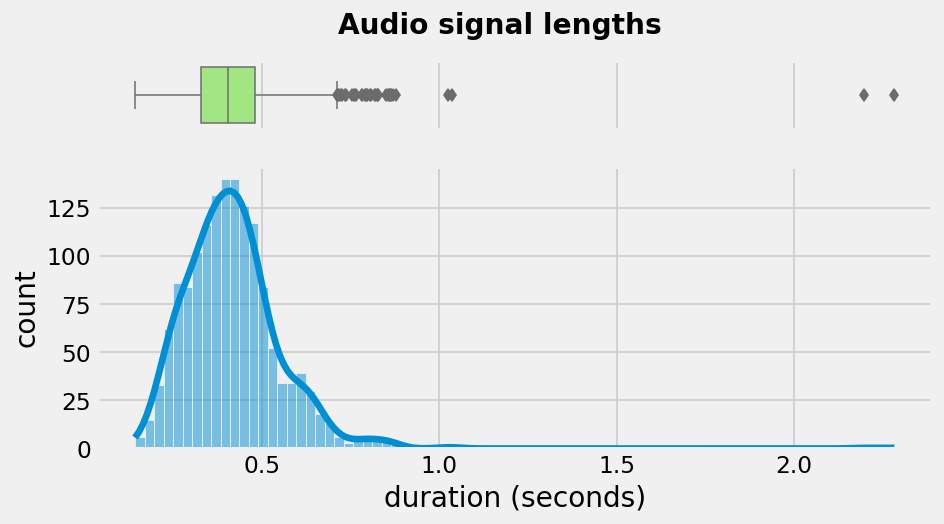

In [2]:
rate = 8000
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(X)


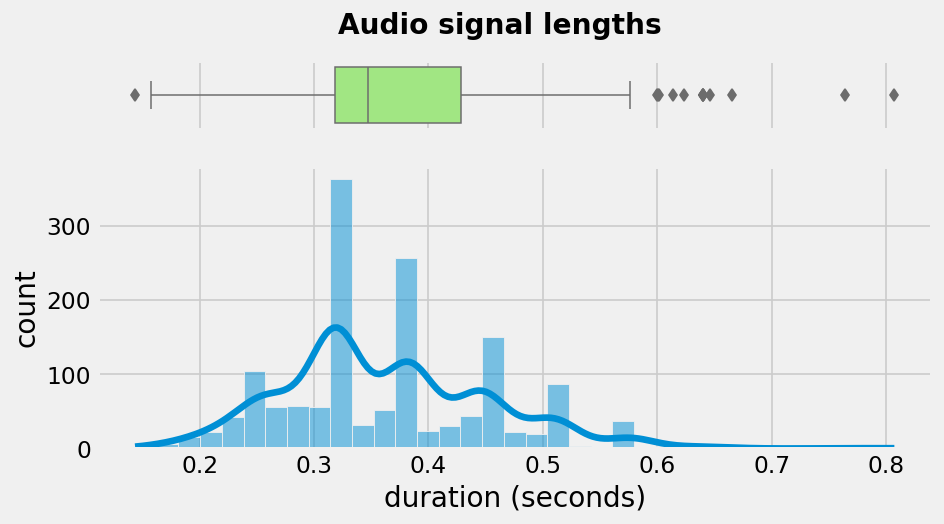

In [3]:
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

In [4]:
N = int(rate * 0.8) # 0.8 is the upper limit of trimmed audio length
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])
def into_bins(X, bins = 20):
    """This functions creates bins of same width and computes mean and standard deviation on those bins
    """
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        As = np.array_split(np.array(x), 20)
        for a in As:
            mean = np.round(a.mean(dtype=np.float64), 4)
            sd = np.round(a.std(dtype=np.float64), 4)
            x_mean_sd.extend([mean, sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

In [5]:
X_time = into_bins(X_uniform, 60)
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size = 0.20, random_state = rs)

NameError: name 'train_test_split' is not defined

In [6]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [7]:
for bins in range(20,101,20):
    X_mean_sd = into_bins(X_uniform, bins)
    X_train, X_test, y_train, y_test = train_test_split(X_mean_sd, y, test_size = 0.20, random_state = rs)
    clf = RFC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    print(f"for {bins} bins, f-macro average:{f.mean()}, accuracy: {acc}")

for 20 bins, f-macro average:0.6281554319565614, accuracy: 0.6333333333333333
for 40 bins, f-macro average:0.6152719714569227, accuracy: 0.62
for 60 bins, f-macro average:0.6377216013989522, accuracy: 0.6433333333333333
for 80 bins, f-macro average:0.6218640520597007, accuracy: 0.6266666666666667
for 100 bins, f-macro average:0.6292654889899074, accuracy: 0.6333333333333333


In [8]:
X_time = into_bins(X_uniform, 60)
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size = 0.20, random_state = rs)

In [9]:
np.savetxt('Xtrain.csv', X_train, delimiter=',')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_uniform, y, test_size = 0.20, random_state = rs)

In [11]:
np.savetxt('Xuniform.csv', X_train, delimiter=',')

In [12]:
np.savetxt('Xtrain.csv', X_train, delimiter=',')
np.savetxt('Xtest.csv', X_test, delimiter=',')
np.savetxt('Ytrain.csv',y_train, delimiter=',')
np.savetxt('Ytest.csv',y_test, delimiter=',')

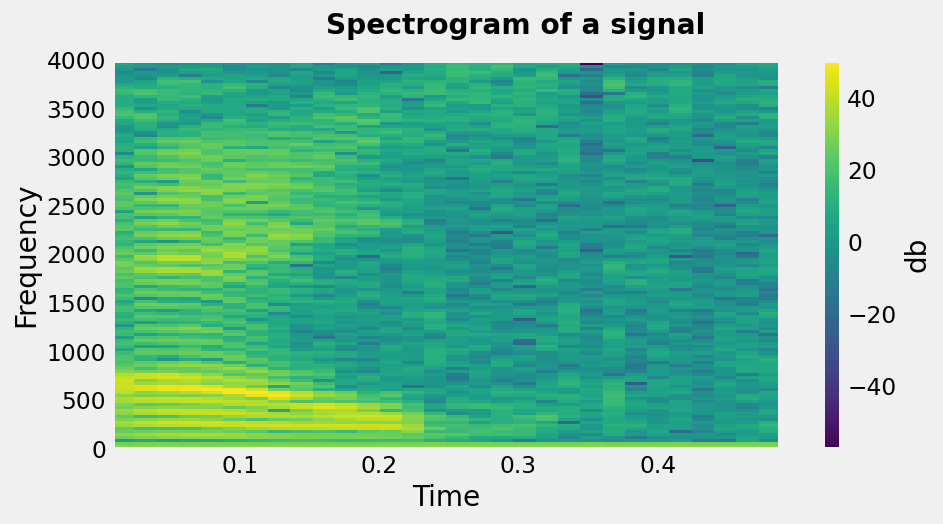

In [15]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[np.random.randint(100)], Fs=rate, scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('db')
plt.grid()
plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   